# Strava-like Hotspot Analysis in Salzburg
This notebook simulates Strava-style GPS activity data and applies spatial statistics to detect and visualize activity hotspots in Salzburg, Austria. We use a synthetic dataset representing typical running or cycling patterns, then compute Getis-Ord Gi* statistics to identify clusters of high or low activity duration. Results are visualized using both an interactive Folium heatmap and a static map with Contextily

# Setup
Uncomment these lines to install these packages if you don't have them installed!

In [ ]:
# !pip install geopandas folium contextily rasterio esda libpysal seaborn plotly

# Import libraries

In [2]:
import matplotlib.pyplot as plt
import geopandas as gpd
import pandas as pd
import folium
from folium.plugins import HeatMap
from shapely.geometry import Point
import contextily as ctx
from esda.getisord import G_Local
from libpysal.weights import KNN

# Load the synthetic data

In [3]:
df = pd.read_csv("synthetic_strava_salzburg.csv")
df.head()

,location,activity_type,duration_min,lat,lon
0,Mirabell Gardens,Ride,22,47.806745,13.044416
1,Mirabell Gardens,Walk,35,47.805793,13.044822
2,Mirabell Gardens,Ride,43,47.806972,13.045866
3,Mirabell Gardens,Walk,23,47.808285,13.045808
4,Mirabell Gardens,Walk,31,47.805649,13.040945


# Are the data types correct?

In [4]:
df["duration_min"] = pd.to_numeric(df["duration_min"], errors="coerce")

# Convert to GeoDataFrame and project to UTM

In [5]:
# convert to gdf using WGS84
gdf = gpd.GeoDataFrame(
    df,
    geometry=gpd.points_from_xy(df["lon"], df["lat"]),
    crs="EPSG:4326"
)

# now reproject to UTM Zone 33N (for Salzburg)
gdf_utm = gdf.to_crs("EPSG:32633")


# Clean + prepare data

In [6]:
# drop missing / invalid values
gdf_utm = gdf_utm.dropna(subset=["duration_min"])
gdf_utm["duration_min"] = gdf_utm["duration_min"].astype(float)

# Create spatial weights matrix

In [ ]:
# create k-nearest neighbor weights (=8)
w = KNN.from_dataframe(gdf_utm, k=8)

# Apply Getis-Ord Gi* hotspot statistic

In [8]:
# compute local z-scores
gi = G_Local(gdf_utm["duration_min"], w)

# now add results to the original gdf
gdf["GiZScore"] = gi.Zs

# Create Folium heatmap

In [9]:
# heatmap data
heat_data = [
    [row["lat"], row["lon"], row["GiZScore"]]
    for _, row in gdf.iterrows()
]

# initialize map + add heatmap layer
m = folium.Map(location=[47.8095, 13.0550], zoom_start=13, tiles="cartodbpositron")
HeatMap(heat_data, radius=12, blur=15, min_opacity=0.2, max_zoom=1).add_to(m)

# show
m

# Static hotspot map with base map

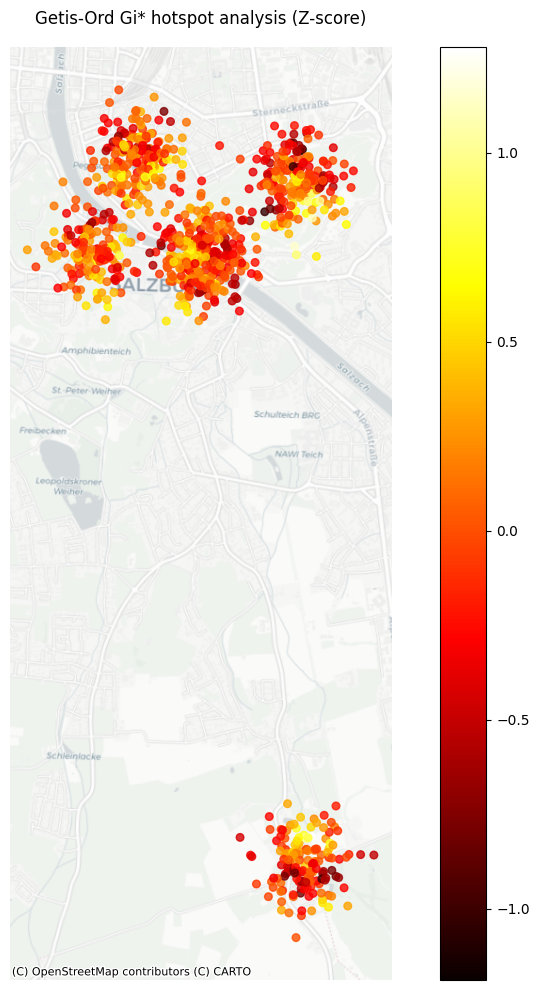

In [10]:
# add z-scores to gdf
gdf_utm["GiZScore"] = gi.Zs

# plot
fig, ax = plt.subplots(figsize=(10, 10))
gdf_utm.plot(
    column="GiZScore",
    cmap="hot",
    legend=True,
    ax=ax,
    alpha=0.8,
    markersize=30
)

ctx.add_basemap(ax, crs=gdf_utm.crs.to_string(), source=ctx.providers.CartoDB.Positron)
plt.title("Getis-Ord Gi* hotspot analysis (Z-score)")
plt.axis("off")
plt.tight_layout()
plt.show()
